In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from src.utils import *
from src.algorithms import * 
from src.metrics_FAMD import *

import warnings

In [2]:
# Fonction to compute metrics for the generated datasets
def compute_metrics(df, cat_idx, n_it, n_components, proba_non_missing):
    """_summary_

    Args:
        df (_type_): _description_
        cat_idx (_type_): _description_
        n_it (_type_): _description_
        n_components (_type_): _description_
        proba_non_missing (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Categorical Variables :
    idx_k2 = pd.Index(cat_idx)
    # Continuous Variables
    idx_k1 = df.columns.difference(idx_k2)

    dict_dfs = {}
    for p in proba_non_missing: 
        df_missing = create_missingness(df, p)
        
        # Encode dummy variables in the dataframe and in the dataframe with missing values :
        df_missing_dummy, idx_j, nb_values_per_cat_df = encode_dummy_variables(df_missing, idx_k2)
        df_dummy = encode_dummy_variables(df, idx_k2)[0]
        dict_dfs.update({p:[idx_k1, idx_j, df_missing_dummy, df_dummy, nb_values_per_cat_df]})

    #IFAMD
    fc_rate = []
    nmrse = []

    for p,values in dict_dfs.items(): 
        k1, k_j, df_missing, df_true, nb_val_per_car = values
        C0_missing, Categ_missing = df_missing.isna()[k1].to_numpy(), df_missing.isna()[k_j].to_numpy()  
        
        #Computation of iterative FAMD
        ifamd_df = IterativeFAMDImputer(n_components=n_components, data=df_missing, k1=k1, k2=k_j, nb_values_per_cat = nb_val_per_car)
        ifamd_df.impute(n_it)
        df = ifamd_df.df

        # We encode categories into 0,1
        res = ifamd_df.df[ifamd_df.k2].copy()
        pos = 0
        for h in range (len(idx_k2)) :
            col = [idx_j[pos+i] for i in range (nb_values_per_cat_df[h])]
            res["max_value"] = ifamd_df.df[col].max(axis = 1)
            for value in col:
                res[value] = (res[value] == res["max_value"]).astype(int)
            pos += nb_values_per_cat_df[h]
        res = res[ifamd_df.k2] 

        #Compute metrics 
        fc_rate.append(metric_fc(res[Categ_missing], df_true[k_j][Categ_missing]))

        # For continuous variables: 
        nmrse.append(compute_nrmse_weighted(df[k1][C0_missing], df_true[k1][C0_missing]))

    fc_rate = np.array(fc_rate)
    nmrse = np.array(nmrse)

    return fc_rate, nmrse, df_missing.columns


In [3]:
# Set random seed to create reproductible results
np.random.seed(21032024)

In [4]:
#Parameters of the first dataset created in the paper : (3.1 Relationships between continuous and categorical variables)

n = 100 # Sample size
S = 2  # 
K = [1,3]  #K[s] = number of times the variable s (s in {1,...,S}) is duplicated in the dataset
cat = 2 #number of categorical variables
cat_idx = [1,2] #index of the categorical variables
nb_of_cat_per_var = [4,4] #number of categories for each categorical variable

df_3_1_snr1 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, 1)
df_3_1_snr3 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, 3)

Initialisation

In [5]:
#Define number of iterations 
n_it = 1000
n_components = 2

# Inject missing values into the dataframe :
proba_non_missing = [0.7, 0.8, 0.9]

n_simulations = 20

In [6]:
nrmse_1, nrmse_3 = [], []
fc_rate_saved1, fc_rate_saved3 = [], []


for n_sim in range(n_simulations):
    df_1_1_snr1 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, 1)
    fc_rate_1, nmrse_1, dc = compute_metrics(df_1_1_snr1, pd.Index(cat_idx).map(str), n_it, n_components, proba_non_missing)
    fc_rate_saved1.append(fc_rate_1)
    nrmse_1.append(nmrse_1)

    # For SNR= 3
    df_3_1_snr3 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, 3)
    fc_rate_3, nmrse_3, _ = compute_metrics(df_3_1_snr3, pd.Index(cat_idx).map(str), n_it, n_components, proba_non_missing)
    fc_rate_saved3.append(fc_rate_3)
    nrmse_3.append(nmrse_3)


# normalization over all iterations 
fc_rate_saved1, fc_rate_saved3= np.array(fc_rate_saved1).mean(axis=0), np.array(fc_rate_saved3).mean(axis=0)
nrmse_1, nrmse_3 = np.array(nrmse_1).mean(axis=0), np.array(nrmse_3).mean(axis=0)

Converged in 4
Converged in 4
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 4
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 4
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 4
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 4
Converged in 4
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 4
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 4
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 3
Converged in 4
Converged in 3
Converged in 3
Converged in 4
Converged in 3
Converged in 3
Converged 

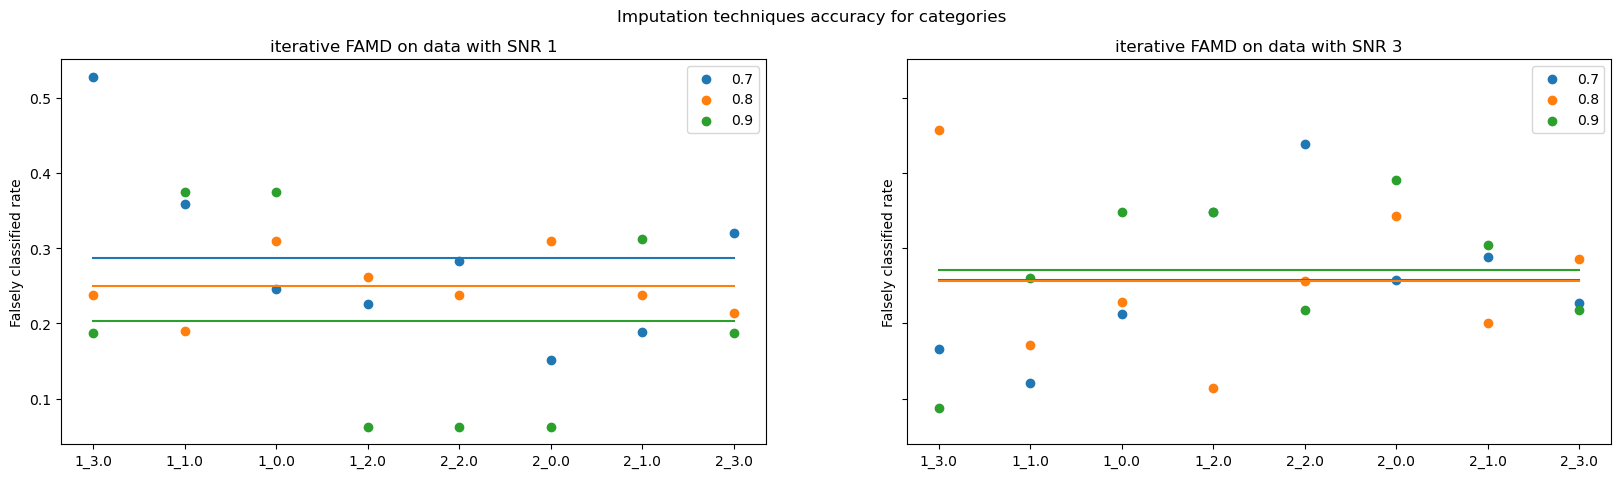

In [7]:
fig, ax = plt.subplots(figsize=(20,5),ncols=2, sharey=True)
fig.suptitle('Imputation techniques accuracy for categories')

k1 = dc[:len(dc) - np.array(nb_of_cat_per_var).sum()]
k2 = dc[len(dc) - np.array(nb_of_cat_per_var).sum():]

for i, vect1 in enumerate(fc_rate_1): 
    ax[0].scatter(k2.to_numpy(), vect1, label=proba_non_missing[i])
    ax[0].plot(k2.to_numpy(),np.ones_like(k2.to_numpy())*vect1.mean())
    ax[0].set_ylabel("Falsely classified rate")
    ax[0].set_title("iterative FAMD on data with SNR 1")
    ax[0].legend()

    vect3 = fc_rate_3[i]
    ax[1].scatter(k2.to_numpy(), vect3, label=proba_non_missing[i])
    ax[1].plot(k2.to_numpy(),np.ones_like(k2.to_numpy())*vect3.mean())
    ax[1].set_ylabel("Falsely classified rate")
    ax[1].set_title("iterative FAMD on data with SNR 3")
    ax[1].legend()

    
#fig.savefig('images/PFC_categories.png')
plt.show()

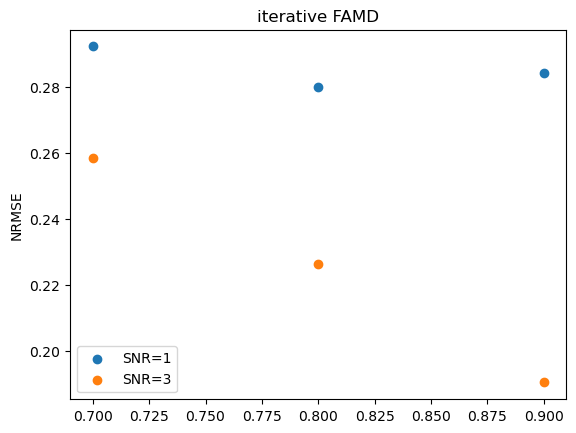

In [9]:
plt.scatter(np.array([0.7,0.8,0.9]), nrmse_1, label='SNR=1')
plt.scatter(np.array([0.7,0.8,0.9]), nrmse_3, label='SNR=3')
plt.ylabel("NRMSE")
plt.title("iterative FAMD")
plt.legend()